## Описание проекта

Вас пригласили на стажировку в отдел аналитики Яндекс.Афиши. Первое задание: помочь маркетологам оптимизировать маркетинговые затраты.

В распоряжении есть данные от Яндекс.Афиши с июня 2017 по конец мая 2018 года:

- лог сервера с данными о посещениях сайта Яндекс.Афиши,
- выгрузка всех заказов за этот период,
- статистика рекламных расходов.

Изучим:

- как люди пользуются продуктом,
- когда они начинают покупать,
- сколько денег приносит каждый клиент
- когда клиент окупается.

## План исследования 

[Шаг 1. Загрузка данных и подготовка их к анализу](#chapter1)

[Шаг 2. Строим отчёты и считаем метрики](#chapter2)
##### Продукт
[-Сколько людей пользуются в день, неделю, месяц?](#chapter3)

[-Сколько сессий в день?](#chapter4)

[-Сколько длится одна сессия?](#chapter5)

[-Как часто люди возвращаются?](#chapter6)
##### [Продажи]
[-Когда люди начинают покупать?](#chapter7)

[-Сколько раз покупают за период?](#chapter9)

[-Какой средний чек?](#chapter10)

[-Сколько денег приносят? (LTV)](#chapter11)

###### [Маркетинг]

[-Сколько денег потратили? Всего / на каждый источник / по времени](#chapter13)

[-Сколько стоило привлечение одного покупателя из каждого источника?](#chapter14)

[-На сколько окупились расходы? (ROI)](#chapter15)

## Загрузим данные и подготовим их к анализу<a class="anchor" id="chapter1"></a>

#### Загрузка библиотек

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats as st
import copy


#### Загрузка датасетов

In [2]:
visits = pd.read_csv('/datasets/visits_log.csv')
orders = pd.read_csv('/datasets/orders_log.csv')
costs = pd.read_csv('/datasets/costs.csv')

Посмотрим общие данные (часть данных датафрейма, содержание NaN, типы и характеристики столбцов) по каждой из таблиц и оптимизируем их для анализа.

## Предобработка таблицы visits

In [3]:
visits.head()

,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


In [4]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
Device       359400 non-null object
End Ts       359400 non-null object
Source Id    359400 non-null int64
Start Ts     359400 non-null object
Uid          359400 non-null uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


In [5]:
visits.duplicated().sum()

0

Меняем названия столбцов и приводим даты в порядок

In [6]:
visits.columns.to_list()

['Device', 'End Ts', 'Source Id', 'Start Ts', 'Uid']

In [7]:
visits.columns = ['device', 'end_ts', 'source_id', 'start_ts', 'uid']

In [8]:
visits = visits[['device', 'source_id', 'uid', 'start_ts', 'end_ts']]

In [9]:
visits['end_ts'] = pd.to_datetime(visits['end_ts'], format = '%Y-%m-%d %H:%M:%S')
visits['start_ts'] = pd.to_datetime(visits['start_ts'], format = '%Y-%m-%d %H:%M:%S')

In [10]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
device       359400 non-null object
source_id    359400 non-null int64
uid          359400 non-null uint64
start_ts     359400 non-null datetime64[ns]
end_ts       359400 non-null datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(1), uint64(1)
memory usage: 13.7+ MB


## Предобработка таблицы orders

In [11]:
orders.head()

,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


In [12]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
Buy Ts     50415 non-null object
Revenue    50415 non-null float64
Uid        50415 non-null uint64
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


In [13]:
orders.duplicated().sum()

0

In [14]:
orders.columns.to_list()

['Buy Ts', 'Revenue', 'Uid']

Аналогично, меняем названия столбцов и приводим даты в порядок

In [15]:
orders.columns = ['purchase_ts', 'revenue', 'uid']

In [16]:
orders = orders[['uid', 'revenue', 'purchase_ts']]

In [17]:
orders['purchase_ts'] = pd.to_datetime(orders['purchase_ts'], format = '%Y-%m-%d %H:%M:%S')

In [18]:
orders.head()

,uid,revenue,purchase_ts
0,10329302124590727494,17.00,2017-06-01 00:10:00
1,11627257723692907447,0.55,2017-06-01 00:25:00
2,17903680561304213844,0.37,2017-06-01 00:27:00
3,16109239769442553005,0.55,2017-06-01 00:29:00
4,14200605875248379450,0.37,2017-06-01 07:58:00


In [19]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
uid            50415 non-null uint64
revenue        50415 non-null float64
purchase_ts    50415 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(1), uint64(1)
memory usage: 1.2 MB


## Предобработка costs

In [20]:
costs.head()

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


In [21]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null object
costs        2542 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


In [22]:
costs.duplicated().sum()

0

In [23]:
costs.columns.to_list()

['source_id', 'dt', 'costs']

In [24]:
costs.columns = ['source_id', 'date', 'costs']

In [25]:
costs = costs[['source_id', 'costs', 'date']]

In [26]:
costs['date'] = pd.to_datetime(costs['date'], format = '%Y-%m-%d')

In [27]:
costs.head()

,source_id,costs,date
0,1,75.20,2017-06-01
1,1,62.25,2017-06-02
2,1,36.53,2017-06-03
3,1,55.00,2017-06-04
4,1,57.08,2017-06-05


In [28]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
costs        2542 non-null float64
date         2542 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 59.7 KB


## 2. Построим отчёты и посчитаем метрики<a class="anchor" id="chapter2"></a>


Продукт
- Сколько людей пользуются в день, неделю, месяц?
- Сколько сессий в день?
- Сколько длится одна сессия?
- Как часто люди возвращаются?

### Сколько людей пользуются в день, неделю, месяц<a class="anchor" id="chapter3"></a>

Для ответа на вопросы по каждой строке добавим информацию по дню недели сессии, по номеру недели и по месяцу. Также добавим столбец с длительностью сессии

In [29]:
visits['duration'] = (visits['end_ts'] - visits['start_ts']).dt.seconds
visits['start_ts_day'] = visits['start_ts'].dt.date
visits['start_ts_week'] = pd.DatetimeIndex(visits['start_ts']).week
visits['start_ts_month'] = pd.DatetimeIndex(visits['start_ts']).month
visits['start_ts_year'] = pd.DatetimeIndex(visits['start_ts']).year

In [30]:
visits.head(10)

,device,source_id,uid,start_ts,end_ts,duration,start_ts_day,start_ts_week,start_ts_month,start_ts_year
0,touch,4,16879256277535980062,2017-12-20 17:20:00,2017-12-20 17:38:00,1080,2017-12-20,51,12,2017
1,desktop,2,104060357244891740,2018-02-19 16:53:00,2018-02-19 17:21:00,1680,2018-02-19,8,2,2018
2,touch,5,7459035603376831527,2017-07-01 01:54:00,2017-07-01 01:54:00,0,2017-07-01,26,7,2017
3,desktop,9,16174680259334210214,2018-05-20 10:59:00,2018-05-20 11:23:00,1440,2018-05-20,20,5,2018
4,desktop,3,9969694820036681168,2017-12-27 14:06:00,2017-12-27 14:06:00,0,2017-12-27,52,12,2017
5,desktop,5,16007536194108375387,2017-09-03 21:35:00,2017-09-03 21:36:00,60,2017-09-03,35,9,2017
6,desktop,1,6661610529277171451,2018-01-30 11:13:00,2018-01-30 12:09:00,3360,2018-01-30,5,1,2018
7,touch,3,11423865690854540312,2017-11-05 15:14:00,2017-11-05 15:15:00,60,2017-11-05,44,11,2017
8,desktop,3,2987360259350925644,2017-07-19 10:41:00,2017-07-19 10:44:00,180,2017-07-19,29,7,2017
9,desktop,5,1289240080042562063,2017-11-08 13:42:00,2017-11-08 13:43:00,60,2017-11-08,45,11,2017


Датафрейм готов.

Теперь посмотрим напосещаемость по дням, неделям и месяцам

In [31]:
dau = visits.groupby(['start_ts_day']).agg({'uid':'nunique'}).mean()
wau = visits.groupby(['start_ts_year', 'start_ts_week']).agg({'uid':'nunique'}).mean()
mau = visits.groupby(['start_ts_year', 'start_ts_month']).agg({'uid':'nunique'}).mean()
print('В день сервисом в среднем пользуются {} людей'.format(int(dau)))
print('В неделю сервисом в среднем пользуются {} людей'.format(int(wau)))
print('В месяц сервисом в среднем пользуются {} людей'.format(int(mau)))

В день сервисом в среднем пользуются 907 людей
В неделю сервисом в среднем пользуются 5716 людей
В месяц сервисом в среднем пользуются 23228 людей


### Сколько сессий в день<a class="anchor" id="chapter4"></a>

Посмотрим на количество сессий в день.

In [32]:
day_visits = visits.groupby(['start_ts_day']).agg({'uid':'count'})
print('В день в среднем проходит {} сессий'.format(int(day_visits.mean()[0])))

В день в среднем проходит 987 сессий


### Сколько длится одна сессия<a class="anchor" id="chapter5"></a>

Постороим график длительности сессий

/opt/conda/lib/python3.7/site-packages/pandas/core/ops/__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


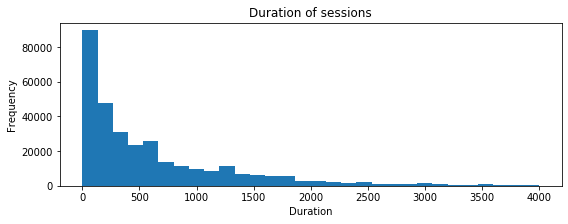

In [33]:
visits['duration'] = (visits['end_ts'] - visits['start_ts']).dt.seconds
mean_session = visits[visits['duration'] != '0 seconds']['duration'].mode()
durations_of_visits = visits[visits['duration'] != 0]['duration']
durations_of_visits.plot(kind = 'hist', bins = 30, figsize = (9,3), range = (0, 4000), 
                         title = 'Duration of sessions').set(xlabel='Duration', ylabel='Frequency')
plt.show()

In [34]:
durations_of_visits.describe()

count    323606.000000
mean        714.684623
std        1047.052806
min          19.000000
25%         120.000000
50%         360.000000
75%         900.000000
max       84480.000000
Name: duration, dtype: float64

In [35]:
print('''Одна сессия длится в среднем {} секунд'''.format(mean_session[0]))

Одна сессия длится в среднем 60 секунд


В нашем случае распределение длительности далеко от нормального, поэтому мы использовали моду (значение, встречающееся чаще всего)

Продолжительность большей части сессий -  1 минута. Фактически, пользователи заходят на сайт и сразу с него уходят.

### Как часто люди возвращаются?<a class="anchor" id="chapter6"></a>

In [36]:
sessions_per_user = len(visits) / len(visits['uid'].unique())
sessions_per_user

1.5751482453795214

В среднем на одного пользователя приходится 1,58 сессий

Полученный показатель подтверждает то, что сервисом пользуются редко.

Построим Retention Rate, чтобы посмотреть как часто возвращаются пользователи в рамках когорт

In [37]:
#найдем первую активность пользователей
first_activity = visits.groupby('uid').agg({'start_ts':'min'})
first_activity.columns = ['first_activity']
visits = visits.join(first_activity, on='uid')

In [38]:
#создадим новый датафрейм чтобы не видеть ненужные столбцы
visits_df2 = visits[['uid', 'first_activity', 'start_ts']]
visits_df2['first_activity_month'] = visits_df2['first_activity'].astype('datetime64[M]')
visits_df2['start_ts_month'] = visits_df2['start_ts'].astype('datetime64[M]')
visits_df2['lifetime'] = ((visits_df2['start_ts_month'] - visits_df2['first_activity_month']) / np.timedelta64(1, 'M')).round().astype('int')
visits_df2.head(5)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

,uid,first_activity,start_ts,first_activity_month,start_ts_month,lifetime
0,16879256277535980062,2017-12-20 17:20:00,2017-12-20 17:20:00,2017-12-01,2017-12-01,0
1,104060357244891740,2018-02-19 16:53:00,2018-02-19 16:53:00,2018-02-01,2018-02-01,0
2,7459035603376831527,2017-07-01 01:54:00,2017-07-01 01:54:00,2017-07-01,2017-07-01,0
3,16174680259334210214,2018-03-09 20:05:00,2018-05-20 10:59:00,2018-03-01,2018-05-01,2
4,9969694820036681168,2017-12-27 14:06:00,2017-12-27 14:06:00,2017-12-01,2017-12-01,0


In [39]:
cohorts_visits = visits_df2.groupby(['first_activity_month', 'lifetime']).agg({'uid':'nunique'}).reset_index()
initial_users_count = cohorts_visits[cohorts_visits['lifetime'] == 0][['first_activity_month', 'uid']]
initial_users_count.columns = ['first_activity_month', 'cohort_users']
initial_users_count = initial_users_count.set_index('first_activity_month')

In [40]:
cohorts_visits = cohorts_visits.join(initial_users_count, on = 'first_activity_month')

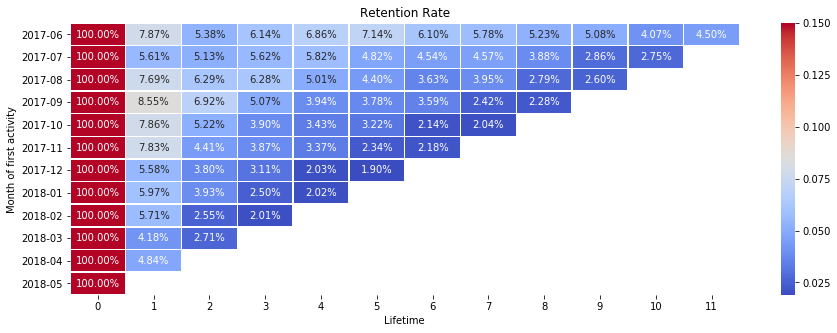

In [41]:
cohorts_visits['retention'] = cohorts_visits['uid'] / cohorts_visits['cohort_users']
retention_pivot = cohorts_visits.pivot_table(index='first_activity_month',
                                      columns='lifetime',
                                      values='retention',
                                      aggfunc='sum')

retention_pivot = retention_pivot.reset_index()
retention_pivot['first_activity_month'] = retention_pivot['first_activity_month'].dt.strftime('%Y-%m')
retention_pivot = retention_pivot.set_index('first_activity_month')
retention_pivot

plt.figure(figsize=(15, 5))
plt.title('Retention Rate')
sns.heatmap(retention_pivot, annot=True, vmax=0.15, fmt=".2%", linewidths=.5, cmap = 'coolwarm')
plt.ylabel('Month of first activity')
plt.xlabel('Lifetime')
plt.show()

In [42]:
#добавим расчет средних значений retention rate по возрастам когорт
retention_pivot_mean = cohorts_visits.groupby('lifetime').agg({'retention': 'mean'})
retention_pivot_mean

,retention
lifetime,
0,1.000000
1,0.065167
2,0.046333
3,0.042760
4,0.040595
5,0.039444
6,0.036957
7,0.037509
8,0.035465


Пользователи возвращаются редко. Retention довольно низкий. После одного месяца пользователя, на второй, возвращается большая часть клиентов, далее, с течением времени, этот процент падает до 2,5-3%.
Это справедливо для всех, кроме самой первой когорты, которая начала пользоваться ресурсом в июне 2017 года. Их Retention тоже довольно низкий, но постоянно находится в лидерах по сравнении со всеми остальными когортами.

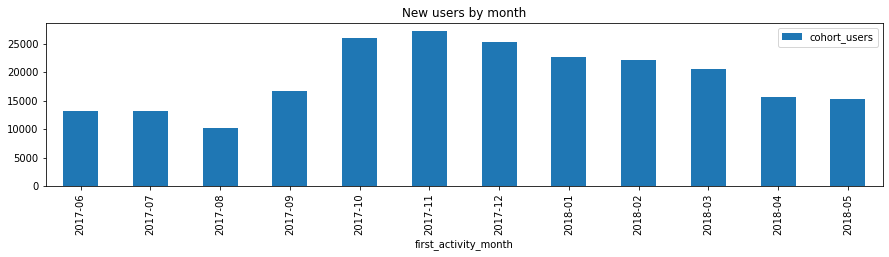

In [43]:
#посмотрим количество новых пользователей по месяцам
cohorts_visits['first_activity_month'] = cohorts_visits['first_activity_month'].dt.strftime('%Y-%m')
cohorts_visits = cohorts_visits.set_index('first_activity_month')
new_users_by_month = cohorts_visits[cohorts_visits['lifetime'] == 0][['cohort_users']]
new_users_by_month.plot(kind = 'bar', figsize = (15,3), title = 'New users by month')
plt.show()

Большинство новых пользователей приходят на ресурс в октябре-декабре. Летом все, вероятно в отпусках и на дачах -- не до культурных мероприятий, а к Новому Году самое оно. Как раз время различных праздничных мероприятий.

### Продажи<a class="anchor" id="chapter7"></a>

##### Когда люди начинают покупать?<a class="anchor" id="chapter8"></a>

In [44]:
#найдём время и дату первой сессии 
first_sessions = visits.groupby(['uid']).agg({'start_ts':'min', 'source_id':'first'})
first_sessions.columns = ['first_activity', 'first_source']

In [45]:
#найдем время первой покупки
first_orders = orders.groupby(['uid']).agg({'purchase_ts':'min'})
first_orders.columns = ['first_purchase_ts']

In [46]:
#добавим дату и время первой сессии в информацию по первым заказам
first_orders = first_orders.join(first_sessions,on='uid')

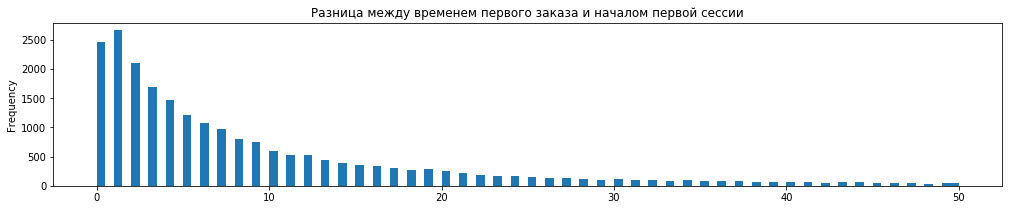

In [47]:
#найдем время, прошедшее с момента первой сессии до первой покупки
first_orders['time_to_first_purchase'] = (first_orders['first_purchase_ts'] - first_orders['first_activity']) / np.timedelta64(1, 'm')
first_orders['time_to_first_purchase'].plot(kind = 'hist', bins = 100, range = (0,50), figsize = (17,3),
                                            title = 'Разница между временем первого заказа и началом первой сессии')


У большей части пользователей на оформление заказа уходит не более 3 минут. Т.е. они заходят ресурс и сразу делают заказ. Видно, что заходят они сразу с конкретным запросом, а не посидеть поискать что-либо интересное.

In [48]:
#Посмотрим медианное время
first_orders['time_to_first_purchase'].median()

16.0

Медианная разница во времени между моментом совершения заказа и датой и временем первого визита - 16 минут.

Теперь посмотрим, как часто пользователи совершают покупки и на средний чек.

#### Сколько раз покупают за период?<a class="anchor" id="chapter9"></a>

За период возьмем месяц. Посмотрим, сколько каждый пользователь делает покупок за "свой" месяц.

In [49]:
orders.head()

,uid,revenue,purchase_ts
0,10329302124590727494,17.00,2017-06-01 00:10:00
1,11627257723692907447,0.55,2017-06-01 00:25:00
2,17903680561304213844,0.37,2017-06-01 00:27:00
3,16109239769442553005,0.55,2017-06-01 00:29:00
4,14200605875248379450,0.37,2017-06-01 07:58:00


In [50]:
#добавим в orders дату первого заказа и выведем в отдельный столбец месяц первого заказа
orders = orders.join(first_orders, on='uid')

In [51]:
orders['first_buy_month'] = orders['first_purchase_ts'].astype('datetime64[M]')
orders['first_session_month'] = orders['first_activity'].astype('datetime64[M]')
orders['buy_month'] = orders['purchase_ts'].astype('datetime64[M]')

In [52]:
orders['buy_date'] = orders['purchase_ts'].dt.date
orders['buy_week'] = orders['purchase_ts'].dt.week
orders['buy_year'] = orders['purchase_ts'].dt.year
day_purchases_per_user = orders.groupby(['buy_date', 'uid']).agg({'purchase_ts':'count'}).mean()[0]
week_purchases_per_user = orders.groupby(['buy_year', 'buy_week', 'uid']).agg({'purchase_ts':'count'}).mean()[0]
month_purchases_per_user = orders.groupby(['buy_month', 'uid']).agg({'purchase_ts':'count'}).mean()[0]
year_purchases_per_user = orders.groupby(['buy_year', 'uid']).agg({'purchase_ts':'count'}).mean()[0]
print('''В среднем на одного пользователя покупок:
В день - {:.1f},
В неделю - {:.1f},
В месяц - {:.1f},
В год - {:.1f}'''.format(day_purchases_per_user, week_purchases_per_user, month_purchases_per_user, year_purchases_per_user))

В среднем на одного пользователя покупок:
В день - 1.1,
В неделю - 1.2,
В месяц - 1.2,
В год - 1.3


Покупок мало, сделаем когортный анализ по количеству покупок на человека - когорты выведем по дате первой сессии

In [53]:
orders = orders[['uid', 'revenue', 'purchase_ts', 'buy_month', 'first_purchase_ts', 'first_buy_month', 'first_session_month']]

In [54]:
#посчитаем lifetime заказов
orders['lifetime_fa_b'] = ((orders['buy_month'] - orders['first_session_month']) / np.timedelta64(1, 'M')).round().astype('int')

In [55]:
#сгруппируем заказы по когортам и lifetime и высчитаем кол-во покупок и пользователей
orders_grouped_by_cohorts = orders.groupby(['first_session_month', 'lifetime_fa_b']).agg({'uid':['count', 
                                                                                                 'nunique']}).reset_index()
orders_grouped_by_cohorts.columns = ['first_session_month', 'lifetime_fa_b', 'n_orders', 'n_users']

In [56]:
#получим количество заказов на одного пользователя по каждой когорте и кадлому lifetime
orders_grouped_by_cohorts['orders_per_user'] = orders_grouped_by_cohorts['n_orders'] / orders_grouped_by_cohorts['n_users']
orders_grouped_by_cohorts['first_session_month'] = orders_grouped_by_cohorts['first_session_month'].dt.strftime('%Y-%m')

In [57]:
#создадим сводную таблицу с когортным анализом количества заказов на пользователя 
cohorts = orders_grouped_by_cohorts.pivot_table(index = 'first_session_month', 
                                                columns = 'lifetime_fa_b', values = 'orders_per_user', aggfunc = 'mean')
cohorts['mean'] = cohorts.mean(axis=1)

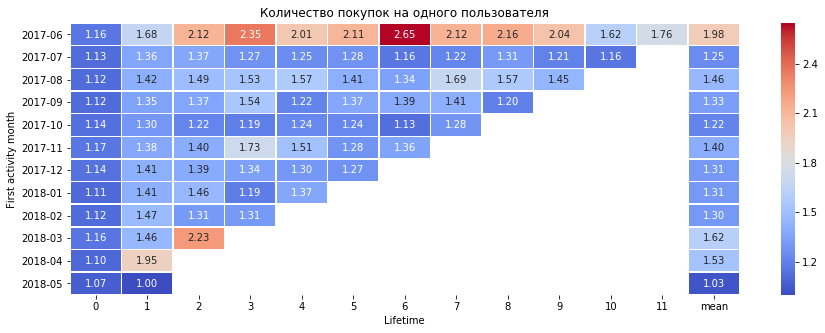

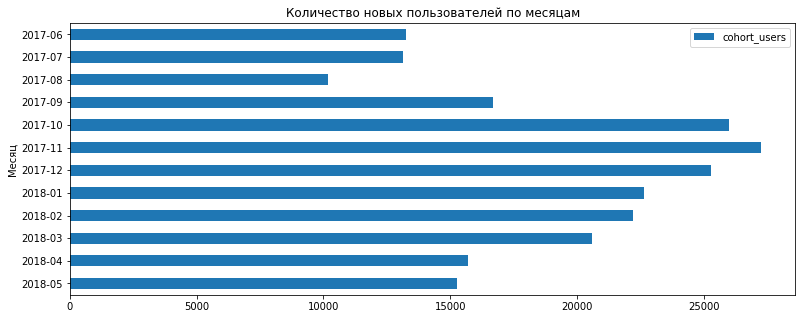

In [58]:
plt.figure(figsize=(15, 5))
plt.title('Количество покупок на одного пользователя')
sns.heatmap(cohorts, annot=True, fmt=".2f", linewidths=.5, cmap = 'coolwarm')
plt.xlabel('Lifetime')
plt.ylabel('First activity month')
plt.show()
new_users_by_month = new_users_by_month.reset_index()
new_users_by_month = new_users_by_month.sort_values(by= 'first_activity_month', ascending = False)
new_users_by_month = new_users_by_month.set_index('first_activity_month')
new_users_by_month.plot(kind = 'barh', figsize = (13,5), title = 'Количество новых пользователей по месяцам')
plt.ylabel('Месяц')
plt.show()

Видим странную картину - в тех когортах, где количество новых пользователей самое большое, мы имеем меньшее количество покупок на 1 пользователя.

Сделаем когортный анализ и посмотрим сколько пользователей делают покупки по истечению времени, когорты сформируем по времени первой активности, жизнь когорты будем смотреть с первой активности до покупки.

In [59]:
orders['first_session_month'] = orders['first_session_month'].dt.strftime('%Y-%m')

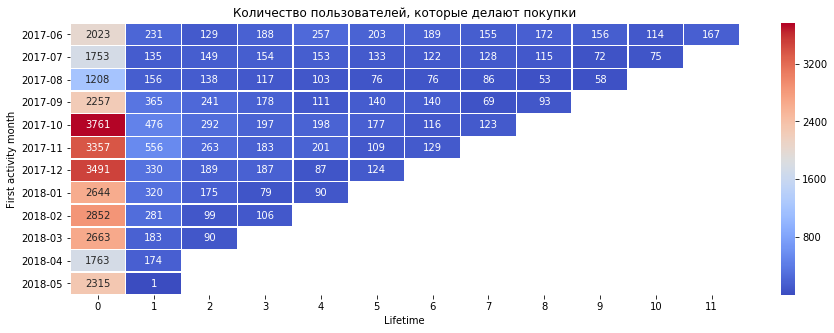

In [60]:
cohorts_buy_n_users = orders.pivot_table(index = 'first_session_month', columns = 'lifetime_fa_b', values = 'uid', aggfunc = 'nunique')
plt.figure(figsize=(15, 5))
plt.title('Количество пользователей, которые делают покупки')
sns.heatmap(cohorts_buy_n_users, annot=True, fmt=".0f", linewidths=.5, cmap = 'coolwarm')
plt.xlabel('Lifetime')
plt.ylabel('First activity month')
plt.show() 

Видим всплеск в октябрьской-декабрьской когортах. Вероятно, это также можно связать с Новогодними мероприятиями и ёлками -- многие покупают билеты.

####  Какой средний чек?<a class="anchor" id="chapter10"></a>

Теперь посмотрим, какой был средний чек по каждой когорте по месяцам:

In [61]:
orders.head()

,uid,revenue,purchase_ts,buy_month,first_purchase_ts,first_buy_month,first_session_month,lifetime_fa_b
0,10329302124590727494,17.00,2017-06-01 00:10:00,2017-06-01,2017-06-01 00:10:00,2017-06-01,2017-06,0
1,11627257723692907447,0.55,2017-06-01 00:25:00,2017-06-01,2017-06-01 00:25:00,2017-06-01,2017-06,0
2,17903680561304213844,0.37,2017-06-01 00:27:00,2017-06-01,2017-06-01 00:27:00,2017-06-01,2017-06,0
3,16109239769442553005,0.55,2017-06-01 00:29:00,2017-06-01,2017-06-01 00:29:00,2017-06-01,2017-06,0
4,14200605875248379450,0.37,2017-06-01 07:58:00,2017-06-01,2017-06-01 07:58:00,2017-06-01,2017-06,0


In [62]:
mean_purchase_by_month = orders.groupby('first_buy_month').agg({'revenue': 'mean'})

In [63]:
month_lst = ['June', 'July', 'August', 'September', 'October', 'November',
             'December', 'January', 'February', 'March', 'April', 'May']

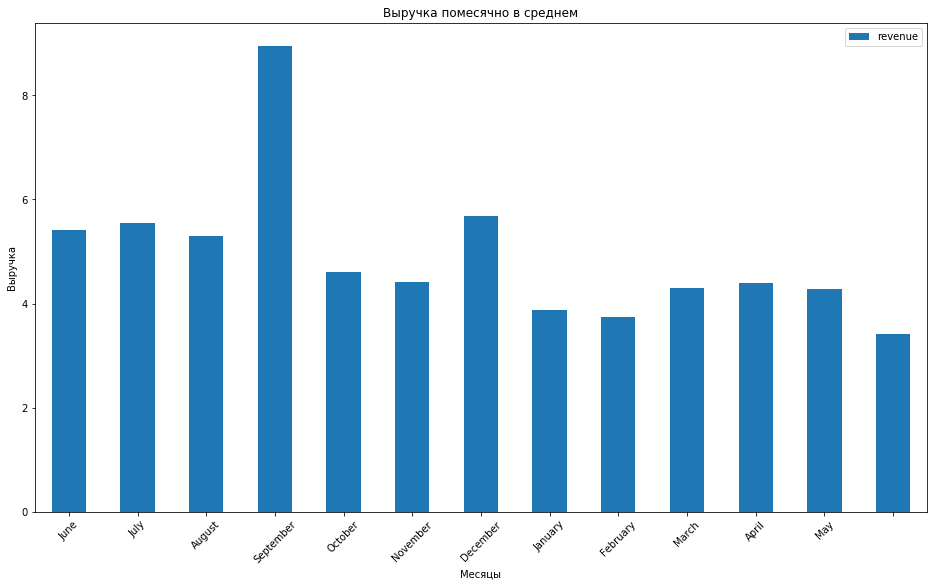

In [64]:
ax = mean_purchase_by_month.plot(kind='bar', figsize=(16, 9))
ax.set_xticklabels(month_lst, rotation=45)
plt.title('Выручка помесячно в среднем')
ax.set_xlabel('Месяцы')
ax.set_ylabel('Выручка')
plt.show()

In [65]:
orders['revenue'].mean()

4.999646930477041

Средний чек равен примерно 5. Можно отметить аномальный месяц - сентябрь. В нём средний чек превышает 8 т.р. Также немного выбивается декабрь (что я продолжаю связывать с праздниками)

Необходимо более подробно исследовать поведение клиентов в эти месяцы, это может нам дать подсказку, как работать в этом направлении.

#### Сколько денег приносят?<a class="anchor" id="chapter11"></a>

###### Рассчитаем LTV

In [66]:
orders.head(10)

,uid,revenue,purchase_ts,buy_month,first_purchase_ts,first_buy_month,first_session_month,lifetime_fa_b
0,10329302124590727494,17.00,2017-06-01 00:10:00,2017-06-01,2017-06-01 00:10:00,2017-06-01,2017-06,0
1,11627257723692907447,0.55,2017-06-01 00:25:00,2017-06-01,2017-06-01 00:25:00,2017-06-01,2017-06,0
2,17903680561304213844,0.37,2017-06-01 00:27:00,2017-06-01,2017-06-01 00:27:00,2017-06-01,2017-06,0
3,16109239769442553005,0.55,2017-06-01 00:29:00,2017-06-01,2017-06-01 00:29:00,2017-06-01,2017-06,0
4,14200605875248379450,0.37,2017-06-01 07:58:00,2017-06-01,2017-06-01 07:58:00,2017-06-01,2017-06,0
5,10402394430196413321,0.18,2017-06-01 08:43:00,2017-06-01,2017-06-01 08:43:00,2017-06-01,2017-06,0
6,12464626743129688638,1.83,2017-06-01 08:54:00,2017-06-01,2017-06-01 08:54:00,2017-06-01,2017-06,0
7,3644482766749211722,1.22,2017-06-01 09:22:00,2017-06-01,2017-06-01 09:22:00,2017-06-01,2017-06,0
8,17542070709969841479,3.30,2017-06-01 09:22:00,2017-06-01,2017-06-01 09:22:00,2017-06-01,2017-06,0
9,1074355127080856382,0.37,2017-06-01 09:23:00,2017-06-01,2017-06-01 09:23:00,2017-06-01,2017-06,0


In [67]:
orders['age_cohort'] = ((orders['buy_month'] - orders['first_buy_month']) / np.timedelta64(1, 'M')).round().astype('int')
cohort_sizes_ltv = orders.groupby('first_buy_month').agg({'uid':'nunique'})
cohort_sizes_ltv.columns = ['cohort_size']
orders_grouped_by_cohorts_ltv = orders.groupby(['first_buy_month', 'age_cohort']).agg({'revenue':'sum', 'uid':'nunique'}).reset_index()
orders_grouped_by_cohorts_ltv = orders_grouped_by_cohorts_ltv.join(cohort_sizes_ltv, on='first_buy_month')
orders_grouped_by_cohorts_ltv['ltv'] = orders_grouped_by_cohorts_ltv['revenue'] / orders_grouped_by_cohorts_ltv['cohort_size']
orders_grouped_by_cohorts_ltv['revenue_per_user'] = orders_grouped_by_cohorts_ltv['revenue'] / orders_grouped_by_cohorts_ltv['uid']

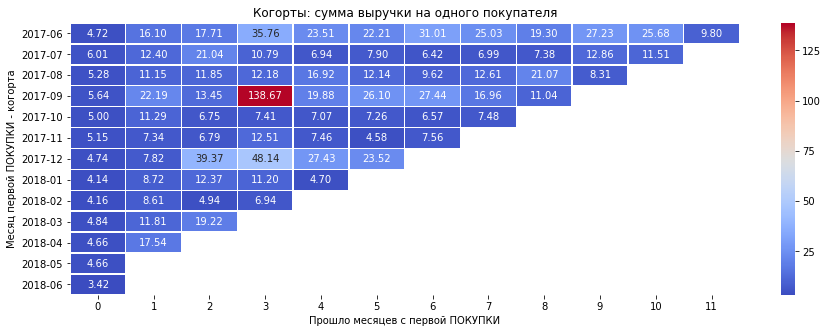

In [68]:
#когортный анализ суммы покупок на одного человека (не LTV)
cohorts_revenue_per_user_2 = orders_grouped_by_cohorts_ltv.pivot_table(
index = 'first_buy_month', columns = 'age_cohort', values = 'revenue_per_user', aggfunc='mean').reset_index()
cohorts_revenue_per_user_2['first_buy_month'] = cohorts_revenue_per_user_2['first_buy_month'].dt.strftime('%Y-%m')
cohorts_revenue_per_user_2 = cohorts_revenue_per_user_2.set_index('first_buy_month')
plt.figure(figsize=(15, 5))
plt.title('Когорты: сумма выручки на одного покупателя')
sns.heatmap(cohorts_revenue_per_user_2, annot=True, fmt=".2f", linewidths=.5, cmap = 'coolwarm')
plt.xlabel('Прошло месяцев с первой ПОКУПКИ')
plt.ylabel('Месяц первой ПОКУПКИ - когорта')
plt.show()

In [69]:
#когортный анализ LTV
# построим сводную таблицу
ltv = orders_grouped_by_cohorts_ltv.pivot_table(
index = 'first_buy_month', columns = 'age_cohort', values = 'ltv', aggfunc = 'mean')
ltv = ltv.cumsum(axis = 1)
ltv = ltv.reset_index()
ltv['first_buy_month'] = ltv['first_buy_month'].dt.strftime('%Y-%m')
ltv = ltv.set_index('first_buy_month')
ltv.loc['mean'] = ltv.mean()
ltv = ltv.round(2)
ltv

age_cohort,0,1,2,3,4,5,6,7,8,9,10,11
first_buy_month,,,,,,,,,,,,
2017-06,4.72,5.21,5.65,6.60,7.62,8.36,9.31,9.89,10.45,11.05,11.62,11.88
2017-07,6.01,6.35,6.97,7.33,7.50,7.66,7.78,7.92,8.08,8.23,8.39,NaN
2017-08,5.28,5.75,6.21,6.60,7.09,7.38,7.59,7.99,8.28,8.47,NaN,NaN
2017-09,5.64,6.76,7.28,11.26,11.66,12.31,13.01,13.25,13.44,NaN,NaN,NaN
2017-10,5.00,5.54,5.73,5.89,6.04,6.16,6.24,6.36,NaN,NaN,NaN,NaN
2017-11,5.15,5.55,5.75,6.08,6.23,6.28,6.40,NaN,NaN,NaN,NaN,NaN
2017-12,4.74,5.00,5.92,6.99,7.30,7.64,NaN,NaN,NaN,NaN,NaN,NaN
2018-01,4.14,4.43,4.73,4.88,4.94,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02,4.16,4.44,4.51,4.59,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


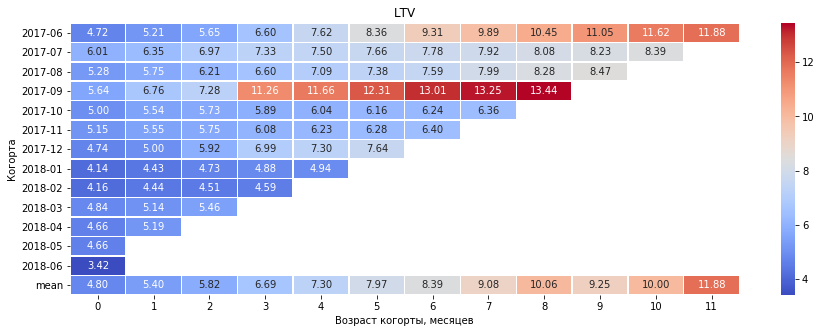

In [70]:
# теперь посмотрим на хитмап 
plt.figure(figsize=(15, 5))
plt.title('LTV')
sns.heatmap(ltv, annot=True, fmt=".2f", linewidths=.5, cmap = 'coolwarm')
plt.xlabel('Возраст когорты, месяцев')
plt.ylabel('Когорта')
plt.show()

Был выведен накопительный ltv. Можно заметить, что первые когорты 2017 года имеют лучшие показатели, нежели последующие - их накопительный LTV заметно выше, чем по остальным когортам.


Также можно отметить, что 1ая когорта была самая стабильная - практически в каждом месяце она показывала лучший результат по LTV среди всех когорт. Вызвано это тем, что именно эта когорта показывает лучший показатель Retention.
По 4ой когорте есть аномальный всплеск месячного значения LTV с третьего месяца жизни.

### Маркетинг<a class="anchor" id="chapter12"></a>

##### Сколько денег потратили? Всего / на каждый источник / по времени<a class="anchor" id="chapter13"></a>

In [71]:
costs.head()

,source_id,costs,date
0,1,75.20,2017-06-01
1,1,62.25,2017-06-02
2,1,36.53,2017-06-03
3,1,55.00,2017-06-04
4,1,57.08,2017-06-05


In [72]:
costs['cost_month'] = costs['date'].astype('datetime64[M]')

print('Всего потрачено на маркетинг {} '.format(costs['costs'].sum()))

Всего потрачено на маркетинг 329131.62 


Всего потрачено на каждый из источников:

In [73]:
costs.groupby('source_id').sum()

,costs
source_id,
1,20833.27
2,42806.04
3,141321.63
4,61073.60
5,51757.10
9,5517.49
10,5822.49


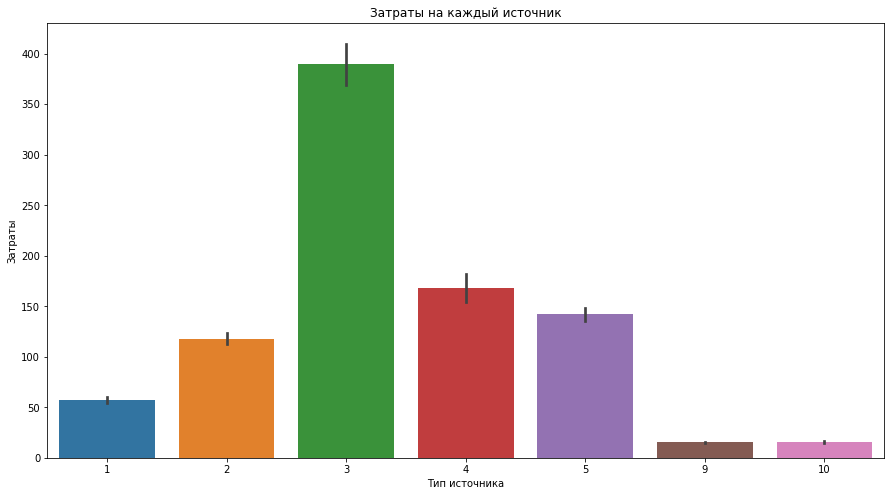

In [74]:
plt.figure(figsize = (15, 8))
ax = sns.barplot(x="source_id", y="costs", data=costs)
plt.title('Затраты на каждый источник')
ax.set_xlabel('Тип источника')
ax.set_ylabel('Затраты')
plt.show()

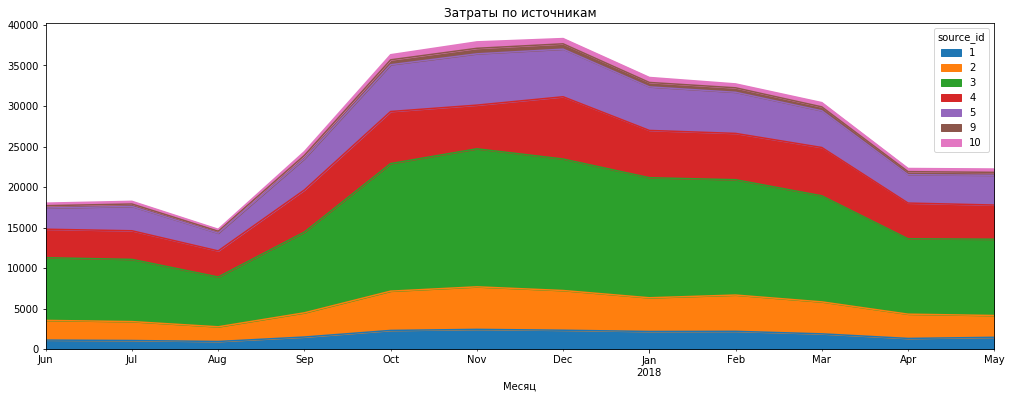

In [75]:
#график затрат по месяцам отдельно для каждого источника
costs_pivot = costs.pivot_table(index = 'cost_month', columns = 'source_id', values = 'costs', aggfunc = 'sum')
costs_pivot.plot.area(figsize = (17,6), title = 'Затраты по источникам')
plt.xlabel('Месяц')
plt.show()


Самый активный период вложений денег в рекламу - с октября 2017г. по март 2018г. 
В остальные периоды активность по заказу рекламы есть, но значительно ниже.

##### Сколько стоило привлечение одного покупателя из каждого источника?<a class="anchor" id="chapter14"></a>

In [76]:
costs_by_source = costs.groupby('source_id').agg({'costs':'sum'})
costs_by_source.reset_index()

,source_id,costs
0,1,20833.27
1,2,42806.04
2,3,141321.63
3,4,61073.60
4,5,51757.10
5,9,5517.49
6,10,5822.49


In [77]:
visits_by_source = visits.query('start_ts == first_activity')
customers_by_source = (orders.merge(visits_by_source, on='uid', how='inner')).groupby('source_id').agg({'uid':'nunique'})\
                        .rename(columns={'uid':'customers'})
customers_by_source.reset_index()

,source_id,customers
0,1,2899
1,2,3506
2,3,10473
3,4,10296
4,5,6931
5,7,1
6,9,1088
7,10,1329


In [78]:
cac = customers_by_source.join(costs_by_source).reset_index()
cac = cac.fillna(0)
cac['cac'] = cac['costs'] / cac['customers']
cac.sort_values('cac', ascending = False)

,source_id,customers,costs,cac
2,3,10473,141321.63,13.493901
1,2,3506,42806.04,12.209367
4,5,6931,51757.10,7.467479
0,1,2899,20833.27,7.186364
3,4,10296,61073.60,5.931779
6,9,1088,5517.49,5.071222
7,10,1329,5822.49,4.381106
5,7,1,0.00,0.000000


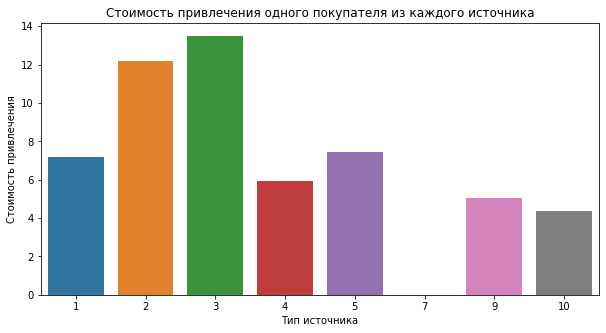

In [79]:
plt.figure(figsize = (10, 5))
ax = sns.barplot(x="source_id", y="cac", data=cac)
plt.title('Стоимость привлечения одного покупателя из каждого источника')
ax.set_xlabel('Тип источника')
ax.set_ylabel('Стоимость привлечения')
plt.show()


В глаза сразу бросается 3ий источник - в него делают больше всего вложений. И, соответственно, он же --  лидер по дороговизне привлечения одного пользователя. 


Тем не менее, по этому графику мы не можем сделать выводы касаемо окупаемости каждого из каналов. Для этого необходимо посчитать ROMI, что мы и сделаем далее.

##### На сколько окупились расходы? <a class="anchor" id="chapter15"></a>

In [80]:
revenue_by_source = (orders.merge(visits_by_source, on='uid', how='inner')).groupby('source_id').agg({'revenue':'sum'})
revenue_by_source.reset_index()

,source_id,revenue
0,1,31090.55
1,2,46923.61
2,3,54511.24
3,4,56696.83
4,5,52624.02
5,7,1.22
6,9,5759.40
7,10,4450.33


In [81]:
roi = revenue_by_source.join(costs_by_source)
roi['roi'] = (roi['revenue'] - roi['costs']) / roi['costs']

In [82]:
roi.sort_values('roi', ascending = False)

,revenue,costs,roi
source_id,,,
1,31090.55,20833.27,0.492351
2,46923.61,42806.04,0.096191
9,5759.40,5517.49,0.043844
5,52624.02,51757.10,0.016750
4,56696.83,61073.60,-0.071664
10,4450.33,5822.49,-0.235665
3,54511.24,141321.63,-0.614275
7,1.22,NaN,NaN


Судя по расчётам, лучший по окупаемости источник №1

Посчитаем ROMI и посмотрим на теплову карту:

In [83]:
orders_grouped_by_cohorts_ltv = orders_grouped_by_cohorts_ltv.set_index('first_buy_month')

In [84]:
costs_by_month = costs.pivot_table(index = 'cost_month', values = 'costs', aggfunc = 'sum').reset_index()
costs_by_month.columns = ['first_buy_month', 'costs']
costs_by_month = costs_by_month.set_index('first_buy_month')

In [85]:
orders_grouped_by_cohorts_ltv = orders_grouped_by_cohorts_ltv.join(costs_by_month, on = 'first_buy_month')
orders_grouped_by_cohorts_ltv['cac'] = orders_grouped_by_cohorts_ltv['costs'] / orders_grouped_by_cohorts_ltv['cohort_size']
orders_grouped_by_cohorts_ltv = orders_grouped_by_cohorts_ltv[:-1]
orders_grouped_by_cohorts_ltv['romi'] = orders_grouped_by_cohorts_ltv['ltv'] / orders_grouped_by_cohorts_ltv['cac']
orders_grouped_by_cohorts_ltv = orders_grouped_by_cohorts_ltv.reset_index()

In [86]:
romi = orders_grouped_by_cohorts_ltv.pivot_table(index = 'first_buy_month', 
                                                 columns = 'age_cohort', values = 'romi', aggfunc = 'mean')

In [87]:
romi = romi.cumsum(axis=1)
romi = romi.reset_index()
romi['first_buy_month'] = romi['first_buy_month'].dt.strftime('%Y-%m')
romi = romi.set_index('first_buy_month')
romi.loc['mean'] = romi.mean()
romi = romi.round(2)

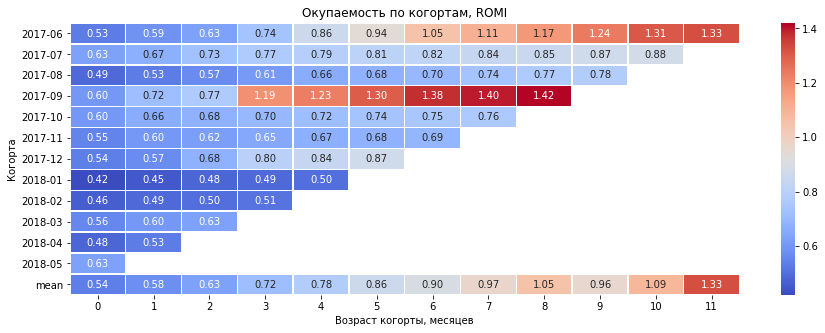

In [88]:
plt.figure(figsize=(15, 5))
plt.title('Окупаемость по когортам, ROMI')
sns.heatmap(romi, annot=True, fmt=".2f", linewidths=.5, cmap = 'coolwarm')
plt.xlabel('Возраст когорты, месяцев')
plt.ylabel('Когорта')
plt.show()

Затраты на маркетинг окупились лишь в июньской и сентябрьской когортах.

Теперь посмотрим на посещаемость ресурса по типу устройства:

In [89]:
revenue_by_source_and_device = (orders.merge(visits_by_source, on='uid', how='inner'))\
                                .groupby(['source_id', 'device']).agg({'revenue':'sum'})

In [90]:
revenue_by_source_and_device = revenue_by_source_and_device.reset_index()

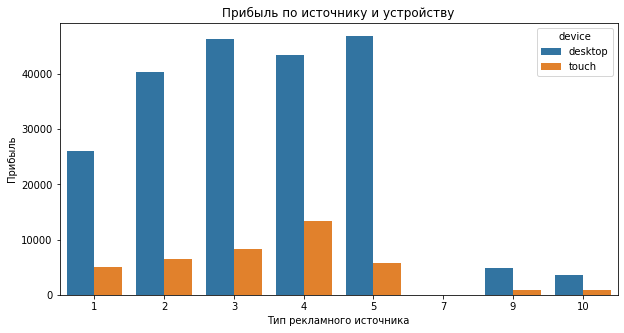

In [91]:
plt.figure(figsize = (10, 5))
ax = sns.barplot(x="source_id", y="revenue", hue="device", data=revenue_by_source_and_device)
plt.title('Прибыль по источнику и устройству')
ax.set_xlabel('Тип рекламного источника')
ax.set_ylabel('Прибыль')
plt.show()

БОльшая часть посещений ресурса совершены с ПК. Учитывая нынешнее время такая низкая посещаемость с мобильных устройств - слабый показатель. Вероятно, причиной тому является тот факт, что сайт не так удобен для использования с мобильного устройства, как с ПК. Ну или дело в особенности рынка - намного удобнее выбирать билеты на мероприятия с компьютера, нежели с телефона. Редко кто покупаем билеты, например, в театр на ходу (исходя из личного опыта)

Можно посоветовать протестировать мобильную версию сайта по части удобства использования, чтобы выяснить, является ли это причиной низкого показателя посещаемости сайта с помощью мобильных устройств.

# Вывод

##### Сервисом пользуются редко, покупки в основном совершаются при первом посещении, причем как правило в течение 1 минуты после захода, т.е. люди заходят на ресурс и, сделав пару щелчков, выходят оттуда. Большая часть клиентов после первой покупки уже не возвращаются. Оставшиеся же совершают в среднем до двух покупки в месяц. Средний чек 1 покупки - 5.
##### Тем не менее самая первая когорта ведет себя необычно по сравнению со всеми остальными: её Retention заметно выше, чем у остальных когорт и пользователи в ней совершают больше покупок в месяц. Необходимо тщательно исследовать эту когорту: как они узнали о ресурсе, что заставляет их продолжать им пользоваться, почему среди прочих всех подобных ресурсов они выбирают именно этот. Также, вероятно, стоит сделать опрос пользователей из других когорт, чтобы составить примерный портрет и понять различие. Это поможет в понимании того, в чём может быть ошибка маркетологов. На основании полученных данных можно будет разработать определенные мероприятия по повышению лояльности среди клиентов, которые пользуются сайтом редко.

##### Чтобы экономика сходилась по клиентам уже через полгода,  необходимо снижать стоимость привлечения клиента.  На текущий момент стратегией маркетинга было использование в основном источника 3 (который оказался убыточным). Необходимо перераспределить вложения в рекламные каналы и сместить акцент с 3 источника, который особо убыточен для компании, на каналы 1(особенно!) и 5, которые являются довольно перспективными, учитывая текущую отдачу при текущих вложениях. По остальным источникам необходимо провести дополнительные исследования и выяснить причины настолько низкой конверсии и провести необходимые мероприятия для исправления ситуации, т.к. в них также делаются довольно солидные рекламные вливания.

##### Так же маркетологам наверное стоит обратить внимание на поведение когорты 2017-09 - данная когорта в декабре сильно вырвалась вперед по выручке, причём подобных увеличений со стороны других когорт в декабре не наблюдалось. Возможно, данное поведение когорты является следствием особенностей рекламной компании и стоит копать в этом направлении, чтобы понять зависимость.

##### Отдельно ещё раз отмечу разницу посещаемости ресурса с ПК и с телефона. С телефона пользователи прктически не заходят, что так же может является причиной редких покупок на сайте. Да, с компьтера это делать намного удобнее, но не всегда есть на это время. Более того, не все ведь имеют под рукой ПК, некоторым он вообще не нужен. Как уже указывалось выше, необходимо пересмотреть рекламную политику компании, необходимо исследовать поведение клиентов, которые остаются и покупают дольше и чаще, чем другие, и необходимо посмотреть в сторону разработки юзабельного мобильного приложения, которое, наконец, дало бы возможность всем без исключения покупать билеты на ходу. 

##### В целом, ситуация не плачевная, легко исправuмая. При акценте маркетологов на более дешевые источники привлечения, грамотном исследовании пользователей которые покупают чаще, а так же направлении фокуса в сторону разработки удобного мобильного приложения сервис вскоре станет окупаемым. Необходимо только провести дополнительные исследования, сформулировать выводы и применить на практике.